In [ ]:
!unzip keras-facenet-h5.zip

In [ ]:
!unzip images.zip

# Triplet Loss
Loss of a single triplet:

$$
||f\left(A^{(i)}\right)-f\left(P^{(i)}\right)||_{2}^{2}+\alpha<||f\left(A^{(i)}\right)-f\left(N^{(i)}\right)||_{2}^{2}
$$

Overall Triplet Loss:

$$
J = \sum^m_{i=1} \mathcal{max}\left(\underbrace{\large\mid\mid f(A^{(i)}) - f(P^{(i)}) \large\mid\mid^2_2}_\text{(1)} - \underbrace{\large\mid\mid f(A^{(i)}) - f(N^{(i)}) \large\mid\mid^2_2}_\text{(2)} + \alpha, 0\right) \tag{3}
$$

**Notes**:
- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; we want this to be small.
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, we want this to be large.
- $\alpha$ is called the margin. It's a hyperparameter that you pick manually. We'll use $\alpha = 0.2$.

In [3]:
def triplet_loss(y_true, y_pred, alpha=0.2):
  '''
  Implementation of the triplet loss as defined by formula (3)

  Arguments:
  y_true -- true labels, required when defining a loss in Keras, we don't need it in this function.
  y_pred -- python list containing three objects:
          anchor -- the encodings for the anchor images, of shape (m, 128)
          positive -- the encodings for the positive images, of shape (m, 128)
          negative -- the encodings for the negative images, of shape (m, 128)
  
  Returns:
  loss -- real number, value of the loss
  '''
  anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
  
  # Compute the (encoding) distance between the anchor and the positive
  pos_dist = tf.subtract(anchor, positive)        # (m, 128)
  pos_dist = tf.square(pos_dist)                  # (m, 128)
  pos_dist = tf.reduce_sum(pos_dist, axis=-1)     # (m, 1)

  # Compute the (encoding) distance between the anchor and the negative
  neg_dist = tf.subtract(anchor, negative)        # (m, 128)
  neg_dist = tf.square(neg_dist)                  # (m, 128)
  neg_dist = tf.reduce_sum(neg_dist, axis=-1)     # (m, 1)

  # Calculate loss for each individual triplet
  loss = tf.subtract(pos_dist, neg_dist)          # (m, 1)
  loss = tf.add(loss, alpha)                      # (m, 1)
  loss = tf.maximum(loss, 0)                      # (m, 1)

  # Calculate the Overall Triplet Loss (formula 3 above) by adding all individual triplet loss
  loss = tf.reduce_sum(loss)                      # (1)

  return loss

# Load model
Load the pretrained FaceNet model

In [6]:
import tensorflow as tf

json_file = open('keras-facenet-h5/model.json', 'r')            # Open the file that contains the FaceNet's structure
model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(model_json)             # Load the FaceNet structure
model.load_weights('keras-facenet-h5/model.h5')         # Load weights of the pretrained FaceNet

In [7]:
# Visualize model's input and output tensors
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


# Face Verification

In [9]:
import numpy as np

def img_to_encoding(image_path, model):
  # Load image with size (160, 160, 3) because FaceNet requires input with that shape
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))     # (160, 160, 3)
  img = np.array(img) / 255.                # (160, 160, 3)
  img = np.expand_dims(img, axis=0)         # (1, 160, 160, 3)
  embedding = model.predict(img)            # (1, 128)
  embedding = embedding / np.linalg.norm(embedding, ord=2)    # Normalize data with L2 norm, data will be in between -1..1
  return embedding                          # (1, 128)

Create a database containing one encoding vector for each person who is allowed to enter the office

In [10]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", model)
database["younes"] = img_to_encoding("images/younes.jpg", model)
database["tian"] = img_to_encoding("images/tian.jpg", model)
database["andrew"] = img_to_encoding("images/andrew.jpg", model)
database["kian"] = img_to_encoding("images/kian.jpg", model)
database["dan"] = img_to_encoding("images/dan.jpg", model)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", model)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", model)
database["kevin"] = img_to_encoding("images/kevin.jpg", model)
database["felix"] = img_to_encoding("images/felix.jpg", model)
database["benoit"] = img_to_encoding("images/benoit.jpg", model)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", model)

Visualize an image and it's encoding data:

[[-0.11412552 -0.10340776 -0.07809163 -0.03147605 -0.01763922 -0.06523111
   0.02861117  0.00100274  0.01058621 -0.05922046  0.09836756 -0.06435186
  -0.01190542 -0.06467694 -0.03796401  0.03856453  0.09536588 -0.02357571
   0.07657545 -0.20027392 -0.07989764 -0.03543159  0.03685693  0.09584758
   0.06027052  0.10280188  0.12235796  0.06458879 -0.02108122 -0.04849022
  -0.10610185  0.03471624 -0.07026923  0.06191644  0.10131975  0.01215316
   0.10428248  0.13829617  0.16360596 -0.01910017  0.00289524  0.07391544
   0.12145932 -0.00237989 -0.0067809   0.00171467  0.08047131 -0.18473281
   0.03718753  0.02368629 -0.10578794  0.12779142  0.10795481 -0.12782809
  -0.0350916   0.2331874   0.03107373  0.06983364  0.10987096 -0.03419939
   0.02939631  0.08816052 -0.12732442  0.05641903  0.025166    0.16943584
   0.04541108  0.13167255 -0.12617192  0.02680608  0.09747158  0.06851086
   0.03508799 -0.15570861  0.02271422  0.07789656 -0.0305734   0.07732681
  -0.17041749 -0.14048794 -0.10063326 

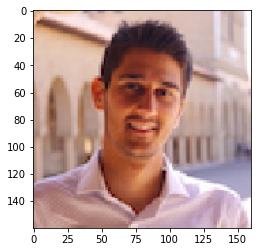

In [11]:
import matplotlib.pyplot as plt
# Load image
kian = tf.keras.preprocessing.image.load_img("images/kian.jpg", target_size=(160, 160))
# Show image
plt.imshow(kian)
# Show encoding
print(database["kian"])

In [12]:
def verify(image_path, identity, database, model, threshold=0.7):
  """
  Function that verifies if the person on the "image_path" image is "identity".
  
  Arguments:
      image_path -- path to an image
      identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
      database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
      model -- your FaceNet model
      threshold -- float, the threshold to accept if an image's encoding is similar to the data in the database
  
  Returns:
      dist -- distance between the image_path and the image of "identity" in the database.
      door_open -- True, if the door should open. False otherwise.
  """
  encoding = img_to_encoding(image_path, model)
  dist = np.linalg.norm(encoding - database[identity])
  if dist < threshold:
    print("It's " + str(identity) + ", welcome in!")
    door_open = True
  else:
    print("It's not " + str(identity) + ", please go away")
    door_open = False

  return dist, door_open

Test the system:

In [13]:
# We feed in the image "camera_1.jpg", which is an image of Bertrand
# Then we test if the system can recognize it is Bertrand's image
dist, door_open = verify("images/camera_1.jpg", "bertrand", database, model)
print(f"Distance: {dist}")
print(f"Door open: {door_open}")

It's bertrand, welcome in!
Distance: 0.5436483025550842
Door open: True


In [17]:
# Now we feed in the image "camera_0.jpg", which is an image of Younes. Let's see if the system can prevent Younes from trying to logging in under Bertrand's identity
dist, door_open = verify("images/camera_0.jpg", "bertrand", database, model)
print(f"Distance: {dist}")
print(f"Door open: {door_open}")

It's not bertrand, please go away
Distance: 1.4408819675445557
Door open: False


# Face Recognition

In [22]:
def who_is_it(image_path, database, model, threshold=0.7):
  '''
  Implements face recognition for the office by finding who is the person on the image_path image.
    
  Arguments:
      image_path -- path to an image
      database -- database containing image encodings along with the name of the person on the image
      model -- your Inception model instance in Keras
      threshold -- threshold to trigger if that person is found in the database
  
  Returns:
      min_dist -- the minimum distance between image_path encoding and the encodings from the database
      identity -- string, the name prediction for the person on image_path
  '''
  encoding = img_to_encoding(image_path, model)
  min_dist = 100
  for (name, db_encoding) in database.items():
    # Compute L2 distance between the target "encoding" and the current db_encoding from the database.
    dist = np.linalg.norm(encoding - db_encoding)

    # If this distance is less than the min_dist, then set min_dist to dist, and identity to name
    if dist < min_dist:
      min_dist = dist
      identity = name
  
  if min_dist < threshold:
    print ("It's " + str(identity) + ", the distance is " + str(min_dist))
  else:
    print("Not in the database.")
  
  return min_dist, identity

Test the system:

In [23]:
who_is_it("images/camera_0.jpg", database, model)     # Should print out Younes

It's younes, the distance is 0.59929454


(0.59929454, 'younes')

In [24]:
who_is_it("images/camera_1.jpg", database, model)     # Should print out Bertrand

It's bertrand, the distance is 0.5436483


(0.5436483, 'bertrand')